In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, multilabel_confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('archive/sign_mnist_train/sign_mnist_train.csv')
test = pd.read_csv('archive/sign_mnist_test/sign_mnist_test.csv')

In [3]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
train.isnull()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27451,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27452,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27453,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [5]:
train.isna().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

In [6]:
train_df_original = train.copy()

# Split into training, test and validation sets
val_index = int(train.shape[0]*0.2)

train_df = train_df_original.iloc[val_index:]
val_df = train_df_original.iloc[:val_index]

In [7]:
y = np.array(train_df['label'])
X = np.array(train_df.drop(columns='label'))

In [8]:
X.shape,y.shape

((21964, 784), (21964,))

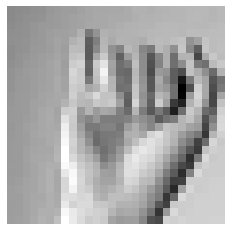

8


In [9]:
import random
r = random.randint(0,(21964-1))
def show_img():
  arr = np.array(X)
  some_value = arr[r]
  some_img = some_value.reshape(28,28)
  plt.imshow(some_img, cmap="gray")
  plt.axis("off")
  plt.show()  

show_img()
print(y[r])

In [10]:
y_train = pd.get_dummies(y)
y_train.head(5)

,0,1,2,3,4,5,6,7,8,10,...,15,16,17,18,19,20,21,22,23,24
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [11]:
y_val = val_df['label']
X_val = val_df.drop(columns="label",axis=1)

In [12]:
y_val = pd.get_dummies(y_val)

In [13]:
y_train.shape 

(21964, 24)

In [14]:
X_val = pd.DataFrame(X_val).values.reshape(X_val.shape[0] ,28, 28, 1)

In [15]:
X_train = pd.DataFrame(X).values.reshape(X.shape[0] ,28, 28, 1)

In [16]:
X_train.shape,y_train.shape

((21964, 28, 28, 1), (21964, 24))

In [17]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=False,
    fill_mode="nearest"
)

X_train_flow = generator.flow(X_train, y_train, batch_size=32)

X_val_flow = generator.flow(X_val, y_val, batch_size=32)

In [18]:
model = Sequential()

model.add(Conv2D(filters=32,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)))
model.add(MaxPool2D((2,2),padding='SAME'))
model.add(Dropout(rate=0.2))


model.add(Conv2D(filters=64,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)))
model.add(MaxPool2D((2,2),padding='SAME'))
model.add(Dropout(rate=0.2))


model.add(Conv2D(filters=521,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)))
model.add(MaxPool2D((2,2),padding='SAME'))
model.add(Dropout(rate=0.2))



model.add(Flatten())
model.add(Dense(units=521, activation="relu"))
model.add(Dense(units=256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=24, activation="softmax"))


model.compile(loss="categorical_crossentropy", optimizer='adam',  metrics=["accuracy"])

2022-05-14 00:36:28.998587: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-14 00:36:29.020304: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd0fb334990 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-14 00:36:29.020320: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 521)         3

In [20]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001
)

In [21]:
history = model.fit(
    X_train_flow,
    validation_data=X_val_flow,
    epochs=100,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(
                   monitor='val_loss',
                   patience=5,
                   restore_best_weights=True
                   ),
      learning_rate_reduction
    ])


Epoch 1/100
687/687 [==============================] - 22s 32ms/step - loss: 3.1026 - accuracy: 0.0669 - val_loss: 2.3715 - val_accuracy: 0.2530
Epoch 2/100
687/687 [==============================] - 22s 32ms/step - loss: 1.4486 - accuracy: 0.5051 - val_loss: 0.5543 - val_accuracy: 0.8124
Epoch 3/100
687/687 [==============================] - 24s 35ms/step - loss: 0.6434 - accuracy: 0.7698 - val_loss: 0.3363 - val_accuracy: 0.8794
Epoch 4/100
687/687 [==============================] - 24s 36ms/step - loss: 0.4049 - accuracy: 0.8582 - val_loss: 0.1456 - val_accuracy: 0.9576
Epoch 5/100
687/687 [==============================] - 24s 35ms/step - loss: 0.2917 - accuracy: 0.9030 - val_loss: 0.0843 - val_accuracy: 0.9803
Epoch 6/100
687/687 [==============================] - 27s 39ms/step - loss: 0.2365 - accuracy: 0.9219 - val_loss: 0.0665 - val_accuracy: 0.9803
Epoch 7/100
687/687 [==============================] - 26s 38ms/step - loss: 0.1818 - accuracy: 0.9420 - val_loss: 0.0358 - val_ac

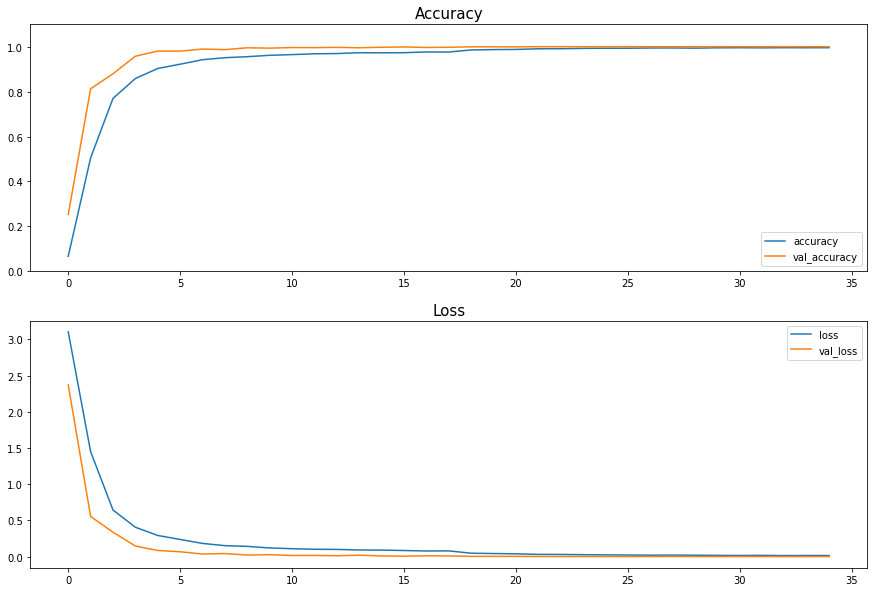

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

In [23]:
y_test = np.array(test['label'])
X_test = np.array(test.drop(columns='label'))

y_test = pd.get_dummies(y_test)
X_test = pd.DataFrame(X_test).values.reshape(X_test.shape[0] ,28, 28, 1)

# X_test_flow = generator.flow(X_test, y_test, batch_size=32)
# X_test.shape,X_train.shape

y_test = pd.get_dummies(y_test)

In [24]:
from sklearn.metrics import classification_report

# predictions
pred = model.predict(X_test)

y_pred = np.argmax(pred,axis=1)
y_test = np.argmax(y_test.values,axis=1)

In [25]:
acc = accuracy_score(y_test,y_pred)

# # Display the results
print(f'## {acc*100:.2f}% accuracy on the test set')

## 98.97% accuracy on the test set


In [26]:
fer_json = model.to_json()
with open("MNIST_Sign.json", "w") as json_file:
    json_file.write(fer_json)
model.save('./MNIST_Sign_tf',save_format='tf')
model.save("MNIST_Sign.h5")
model.save_weights("MNIST_Sign.h5")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2022-05-14 00:50:26.191298: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./MNIST_Sign_tf/assets
